In [67]:
import pickle
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot  as plt
import FinanceDataReader as fdr
import warnings
from datetime import datetime, timedelta

warnings.filterwarnings(action='ignore')

In [102]:
# 확인하면 되는 것들
std_date = '20190603'
N = 1000

DATA_PATH = f'./db_and_model/stock_data_{std_date}_{N}.csv'

In [103]:
def date_add(date, month):
    '''date에 month만큼 더해준다. date는 20210102와 같은 꼴이나 datetime type으로 입력한다.'''
    if type(date) == str: # date가 datetime이 아니라 str 타입으로 들어온 경우
        date = datetime.strptime(date, '%Y%m%d')
    delta = timedelta(days=month*30.5)
    return date + delta

def earning_rate(stock_price : list, start_date, end_date):
    '''start_date부터 end_date까지 stock_price데이터를 가지고 수익률을 구해주는 함수(종가 기준)'''
    possible_start_date = stock_price[stock_price.index >= start_date].index[0]
    possible_end_date = stock_price[stock_price.index <= end_date].index[-1]
    
    start_price = stock_price.loc[possible_start_date].Close
    end_price = stock_price.loc[possible_end_date].Close
    
    return (end_price - start_price) / start_price

def preprocess(data_path):
    """데이터 불러오기 + 전처리"""
    # raw_data = pd.read_csv(data_path, encoding='cp949')
    raw_data = pd.read_csv(data_path)
    raw_data.drop(raw_data[raw_data['PER'] == 0].index, inplace=True) # PER 0인 종목 제외
    raw_data.drop(raw_data[raw_data['PBR'] == 0].index, inplace=True) # PBR 0인 종목 제외

    return raw_data.reset_index()

def pred(data_path=DATA_PATH):
    raw_data = preprocess(data_path)

    col_names = ["12개월 간 수익률", "KOSPI대비 12개월 간 수익률" , "12개월 간 KOSPI 이김" , 'PER_inv' , 'PBR_inv' , "배당수익률"]
    X = raw_data[col_names]

    MODEL_FILEPATH = './db_and_model/stock_pred_model.pkl'
    with open(MODEL_FILEPATH, 'rb') as pickle_file:
        stock_pred_model = pickle.load(pickle_file)

    y = stock_pred_model.predict_proba(X)[:, 1]
    y = pd.DataFrame(y, columns=['y'])

    # 결과 dataFrame
    res = raw_data.copy()
    res['y'] = y.values

    return res

res = pred()

top_stocks = res.sort_values(by='y', ascending=False).head(50)

top_stocks.head(50)

,index,Unnamed: 0,date,code,12개월 간 수익률,name,KOSPI 12개월 간 수익률,KOSPI대비 12개월 간 수익률,12개월 간 KOSPI 이김,PER,PBR,배당수익률,PER_inv,PBR_inv,y
688,702,702,20190603,125210,0.225490,아모그린텍,-0.155207,0.380697,1,10000.00,100.00,0.00,0.000100,0.010000,0.814545
677,691,691,20190603,128820,-0.265403,대성산업,-0.155207,-0.110196,0,10000.00,0.44,0.00,0.000100,2.272727,0.799832
44,44,44,20190603,034220,-0.268398,LG디스플레이,-0.155207,-0.113191,0,10000.00,0.43,0.00,0.000100,2.325581,0.775087
836,853,853,20190603,115160,-0.286687,휴맥스,-0.155207,-0.131480,0,10000.00,0.41,0.00,0.000100,2.439024,0.771176
400,405,405,20190603,174900,0.216450,앱클론,-0.155207,0.371657,1,10000.00,21.52,0.00,0.000100,0.046468,0.765288
517,528,528,20190603,136480,-0.101583,하림,-0.155207,0.053624,1,10000.00,1.00,0.00,0.000100,1.000000,0.758319
252,253,253,20190603,263050,0.216389,유틸렉스,-0.155207,0.371596,1,10000.00,8.90,0.00,0.000100,0.112360,0.754172
861,878,878,20190603,096775,-0.128205,SK이노베이션우,-0.155207,0.027002,1,10000.00,10000.00,6.76,0.000100,0.000100,0.736341
334,336,336,20190603,00680K,-0.175055,미래에셋대우2우B,-0.155207,-0.019847,0,10000.00,10000.00,5.84,0.000100,0.000100,0.734256
781,796,796,20190603,023600,0.173735,삼보판지,-0.155207,0.328942,1,2.89,0.52,0.47,0.346021,1.923077,0.733311


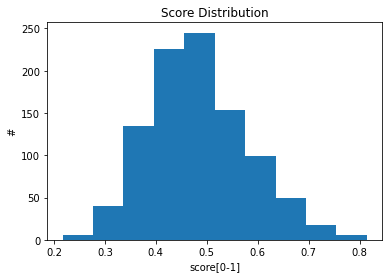

In [104]:
fig = plt.figure()
plt.hist(res['y'])
plt.title('Score Distribution')
plt.xlabel('score[0-1]')
plt.ylabel('#')
plt.show()

In [107]:
top_stocks = res.sort_values(by='y', ascending=False).head(50)

end_date = date_add(date=std_date, month=6) # std_date에 month 이후

stock_price_dic = {}

for code in top_stocks.code:
    stock_price_dic[code] = fdr.DataReader(code, start=std_date)

er_list = []
for code in top_stocks.code:
    er = earning_rate(stock_price_dic[code], start_date=std_date, end_date=end_date)
    er_list.append(er)

top_stocks['수익률'] = er_list

print('수익률 : {:.4f}%'.format(top_stocks['수익률'].mean()*100))
top_stocks.head(50)

수익률 : -10.2971%


,index,Unnamed: 0,date,code,12개월 간 수익률,name,KOSPI 12개월 간 수익률,KOSPI대비 12개월 간 수익률,12개월 간 KOSPI 이김,PER,PBR,배당수익률,PER_inv,PBR_inv,y,수익률
688,702,702,20190603,125210,0.225490,아모그린텍,-0.155207,0.380697,1,10000.00,100.00,0.00,0.000100,0.010000,0.814545,-0.128000
677,691,691,20190603,128820,-0.265403,대성산업,-0.155207,-0.110196,0,10000.00,0.44,0.00,0.000100,2.272727,0.799832,-0.307527
44,44,44,20190603,034220,-0.268398,LG디스플레이,-0.155207,-0.113191,0,10000.00,0.43,0.00,0.000100,2.325581,0.775087,-0.112426
836,853,853,20190603,115160,-0.286687,휴맥스,-0.155207,-0.131480,0,10000.00,0.41,0.00,0.000100,2.439024,0.771176,-0.290501
400,405,405,20190603,174900,0.216450,앱클론,-0.155207,0.371657,1,10000.00,21.52,0.00,0.000100,0.046468,0.765288,-0.370996
517,528,528,20190603,136480,-0.101583,하림,-0.155207,0.053624,1,10000.00,1.00,0.00,0.000100,1.000000,0.758319,-0.218796
252,253,253,20190603,263050,0.216389,유틸렉스,-0.155207,0.371596,1,10000.00,8.90,0.00,0.000100,0.112360,0.754172,-0.401053
861,878,878,20190603,096775,-0.128205,SK이노베이션우,-0.155207,0.027002,1,10000.00,10000.00,6.76,0.000100,0.000100,0.736341,-0.071429
334,336,336,20190603,00680K,-0.175055,미래에셋대우2우B,-0.155207,-0.019847,0,10000.00,10000.00,5.84,0.000100,0.000100,0.734256,0.131300
781,796,796,20190603,023600,0.173735,삼보판지,-0.155207,0.328942,1,2.89,0.52,0.47,0.346021,1.923077,0.733311,-0.245283


In [96]:
# 금융주, 지주 회사 제외 테스트
condition = ~(res.name.str.contains('지주') | res.name.str.contains('홀딩스')
    | res.name.str.contains('은행') | res.name.str.contains('금융') | res.name.str.contains('보험')
     | res.name.str.contains('증권') | res.name.str.contains('생명'))

top_stocks2 = res[condition].sort_values(by='y', ascending=False).head(50)

end_date = date_add(date=std_date, month=6) # std_date에 month 이후

stock_price_dic = {}

for code in top_stocks2.code:
    stock_price_dic[code] = fdr.DataReader(code, start=std_date)

er_list = []
for code in top_stocks2.code:
    er = earning_rate(stock_price_dic[code], start_date=std_date, end_date=end_date)
    er_list.append(er)

top_stocks2['수익률'] = er_list

print('수익률 : {:.4f}%'.format(top_stocks2['수익률'].mean()*100))
top_stocks2.head(50)

수익률 : -12.5574%


,index,Unnamed: 0,date,code,12개월 간 수익률,name,KOSPI 12개월 간 수익률,KOSPI대비 12개월 간 수익률,12개월 간 KOSPI 이김,PER,PBR,배당수익률,PER_inv,PBR_inv,y,수익률
835,853,853,20210601,200880,1.739541,서연이화,0.560167,1.179374,1,10000.00,0.46,0.99,0.000100,2.173913,0.725775,-0.357635
686,702,702,20210601,001520,-0.017544,동양,0.560167,-0.577711,0,10000.00,0.43,2.86,0.000100,2.325581,0.708627,0.003571
312,318,318,20210601,012630,0.514196,HDC,0.560167,-0.045972,0,7.70,0.38,1.74,0.129870,2.631579,0.688533,-0.319444
72,73,73,20210601,078930,0.243208,GS,0.560167,-0.316959,0,10000.00,0.54,3.95,0.000100,1.851852,0.682714,-0.211238
944,965,965,20210601,160980,0.617100,싸이맥스,0.560167,0.056933,1,9.73,1.87,1.61,0.102775,0.534759,0.673061,-0.239080
279,283,283,20210601,006120,0.854419,SK디스커버리,0.560167,0.294252,1,4.09,0.56,1.87,0.244499,1.785714,0.668862,-0.173832
616,631,631,20210601,017940,0.520436,E1,0.560167,-0.039731,0,5.35,0.32,3.94,0.186916,3.125000,0.663701,-0.177419
165,166,166,20210601,294870,0.466501,HDC현대산업개발,0.560167,-0.093666,0,8.16,0.71,2.03,0.122549,1.408451,0.658697,-0.277496
937,958,958,20210601,002170,0.474074,삼양통상,0.560167,-0.086093,0,4.54,0.64,1.57,0.220264,1.562500,0.657597,-0.271357
867,885,885,20210601,054780,0.052817,키이스트,0.560167,-0.507350,0,26.70,6.13,0.00,0.037453,0.163132,0.648597,-0.193980


-1.9805692009306781

수익률 : -1.9806%
